# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL pipeline.
### 1. Import libraries and load datasets.
- Import Python libraries
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [2]:
# import libraries
import pandas as pd
from collections import Counter
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [3]:
# load messages dataset
messages = pd.read_csv('messages.csv', index_col=0)
print(f'The file has rows x columns = {messages.shape}')
messages.head()

The file has rows x columns = (26248, 3)


,message,original,genre
id,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [4]:
# No missing values in message and genre columns
messages.isna().sum(0)

message         0
original    16064
genre           0
dtype: int64

In [5]:
# load categories dataset
categories = pd.read_csv('categories.csv', index_col=0)
print(f'The file has rows x columns = {categories.shape}')
categories.head()

The file has rows x columns = (26248, 1)


,categories
id,
2,related-1;request-0;offer-0;aid_related-0;medi...
7,related-1;request-0;offer-0;aid_related-1;medi...
8,related-1;request-0;offer-0;aid_related-0;medi...
9,related-1;request-1;offer-0;aid_related-1;medi...
12,related-1;request-0;offer-0;aid_related-0;medi...


In [6]:
# No missing values
categories.isna().sum(0)

categories    0
dtype: int64

In [7]:
messages_idx = messages.index.tolist()
categories_idx = categories.index.tolist()
# there are a few index in double in both datasets
#print(len(set(categories_idx)), len(set(messages_idx)))
print('Indices not present in both lists', list(set(messages_idx) - set(categories_idx)))

idx_count = Counter()
idx_count.update(messages_idx)
non_unique_idx = []
for k,v in idx_count.items():
    if v>1:
        non_unique_idx.append(k)
print(f'There are {len(non_unique_idx)} indices which are not unique')

Indices not present in both lists []
There are 67 indices which are not unique


In [8]:
messages.loc[non_unique_idx,:]

,message,original,genre
id,,,
202,?? port au prince ?? and food. they need gover...,p bay pap la syen ak manje. Yo bezwen ed gouve...,direct
202,?? port au prince ?? and food. they need gover...,p bay pap la syen ak manje. Yo bezwen ed gouve...,direct
804,elle est vraiment malade et a besoin d'aide. u...,she is really sick she need your help. please ...,direct
804,elle est vraiment malade et a besoin d'aide. u...,she is really sick she need your help. please ...,direct
862,What is the address of the radio station? I as...,Ki adres radyo a? Paske m bezwen al depoze dos...,direct
...,...,...,...
28687,"At present, UNHCR has 2,500 additional tents a...",NaN,news
29022,"In a field in Jallouzai, just inside Pakistan,...",NaN,news
29022,"In a field in Jallouzai, just inside Pakistan,...",NaN,news


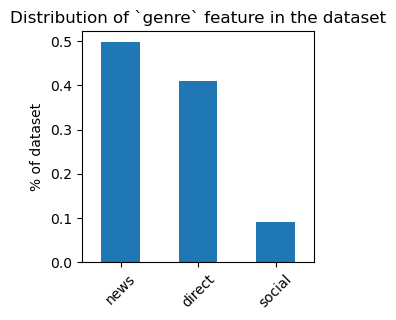

In [10]:
messages.genre.value_counts(normalize=True).plot(kind='bar', figsize=(3,3),rot=45)
plt.title('Distribution of `genre` feature in the dataset')
plt.ylabel('% of dataset')
plt.show()

### 2. Merge datasets.
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`, which will be cleaned in the following steps

In [9]:
# merge datasets
df = messages.join(categories, on='id') #pd.merge(messages,categories,on='id' )
print(f'The file has rows x columns = {df.shape}')
df.head()

The file has rows x columns = (26386, 4)


,message,original,genre,categories
id,,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...


### 3. Split `categories` into separate category columns.
- Split the values in the `categories` column on the `;` character so that each value becomes a separate column. You'll find [this method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.split.html) very helpful! Make sure to set `expand=True`.
- Use the first row of categories dataframe to create column names for the categories data.
- Rename columns of `categories` with new column names.

In [10]:
# create a dataframe of the 36 individual category columns
categories = categories.categories.str.split(pat=';', expand=True)
categories.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
id,,,,,,,,,,,,,,,,,,,,,
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
7,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
8,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
9,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
12,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [11]:
# select the first row of the categories dataframe
row = categories.iloc[0,:].tolist()

# use this row to extract a list of new column names for categories.
# one way is to apply a lambda function that takes everything 
# up to the second to last character of each string with slicing
category_colnames = [col_name[:-2] for col_name in row]
print(category_colnames)

['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [12]:
# rename the columns of `categories`
categories.columns = category_colnames
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
7,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
8,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
9,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
12,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


### 4. Convert category values to just numbers 0 or 1.
- Iterate through the category columns in df to keep only the last character of each string (the 1 or 0). For example, `related-0` becomes `0`, `related-1` becomes `1`. Convert the string to a numeric value.
- You can perform [normal string actions on Pandas Series](https://pandas.pydata.org/pandas-docs/stable/text.html#indexing-with-str), like indexing, by including `.str` after the Series. You may need to first convert the Series to be of type string, which you can do with `astype(str)`.

In [13]:
for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].astype(str).str[-1]
    
    # convert column from string to numeric
    categories[column] = categories[column].astype(int)
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


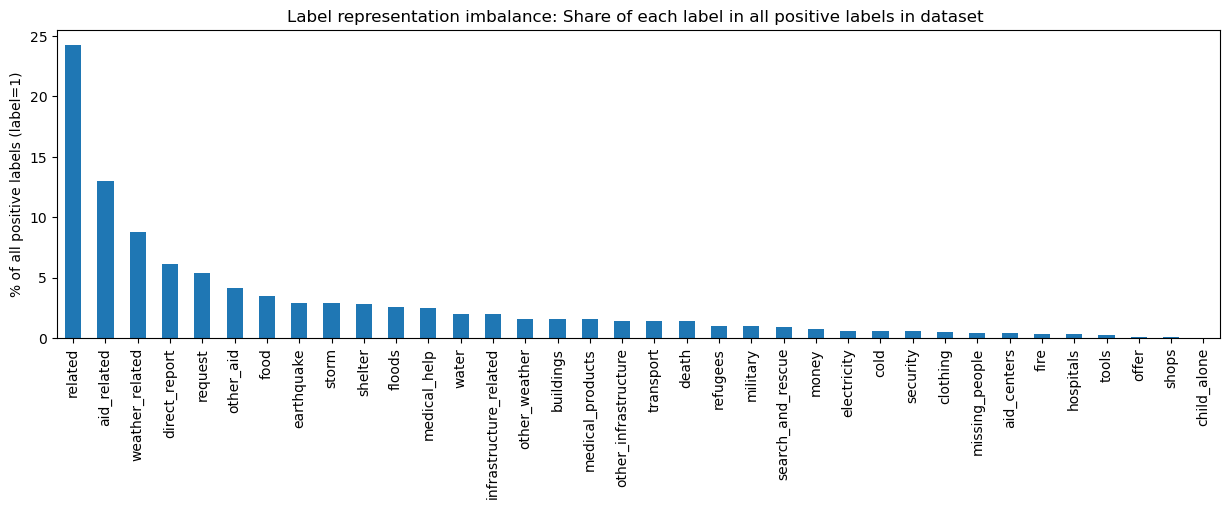

In [48]:
(categories.sum(axis=0) / categories.sum().sum() * 100).round(1).sort_values(ascending=False).plot(kind='bar', figsize=(15,4))
plt.ylabel('% of all positive labels (label=1)')
plt.title('Label representation imbalance: Share of each label in all positive labels in dataset ')
plt.show()

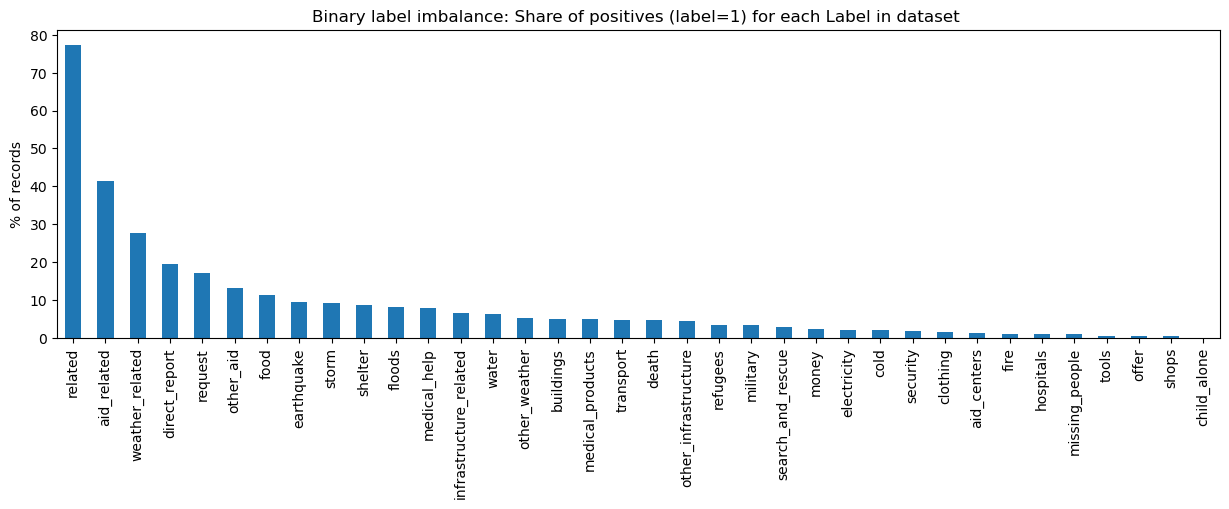

In [46]:
(categories.sum(axis=0) / len(categories) * 100).round(1).sort_values(ascending=False).plot(kind='bar', figsize=(15,4))
plt.ylabel('% of records')
plt.title('Binary label imbalance: Share of positives (label=1) for each Label in dataset ')
plt.show()

In [15]:
# 'Child alone' label has no positive record
categories.loc[:,categories.sum(axis=0) ==0]

,child_alone
id,
2,0
7,0
8,0
9,0
12,0
...,...
30261,0
30262,0
30263,0


- what is the category "related" with close to 80% of the records ? 

In [16]:
categories[categories.related==0].sum(axis=0).sum(0)

0

- we can see that the records "related=0" are not classified with any label

## Conclusion categories data exploration
- a record can be related (related=1) and the assigned to one or multiple emergency labels
- a record can be not related (related=0) and, in that case, not assigned to any emergency labels. This is noise.
- The dataset does contain only negative samples for 'child alone'

### 5. Replace `categories` column in `df` with new category columns.
- Drop the categories column from the df dataframe since it is no longer needed.
- Concatenate df and categories data frames.
- there are 35 emergency labels and a related / not related flag

In [118]:
# drop the original categories column from `df`
df.drop('categories', axis=1, inplace=True)
df.head()

,message,original,genre
id,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [17]:
# concatenate the original dataframe with the new `categories` dataframe
#df = pd.concat([messages, categories], axis=1)
df = messages.join(categories, on='id') #pd.merge(messages,categories,on='id' )
print(f'The file has rows x columns = {df.shape}')
df.head()

The file has rows x columns = (26386, 39)


,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Remove duplicates.
- Check how many duplicates are in this dataset.
- Drop the duplicates.
- Confirm duplicates were removed.

In [18]:
# check number of duplicates
duplicates_df = df.loc[df.duplicated(keep='first').tolist(),:]
print(f'There are {len(duplicates_df)} duplicated entries')

There are 171 duplicated entries


In [19]:
# drop duplicates
df = df.drop_duplicates()
print(f'The file has rows x columns = {df.shape}')
df.head()

The file has rows x columns = (26215, 39)


,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# check number of duplicates
print(f'There are {len(df.loc[df.duplicated().tolist(),:])} duplicated entries')

There are 0 duplicated entries


- Exploration of 'genre' feature

In [187]:
df_direct = df[df.genre=='direct']
df_direct

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14675,"shikarpur: Volunteers needed, food and medical...",shikarpur mein swanyasevak ki avyashaktha he.k...,direct,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
14676,"Dadu: Needs water, food, medicines. boats","JO KO KHANA, PAANI, DAWAYIAN, NAOV CHAHIYE.",direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
14678,Abarho Gotki: No aid being reached to the area,NaN,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
df_news = df[df.genre=='news']
df_news

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
15730,UNICEF is also upgrading solid waste managemen...,NaN,news,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15731,China periodically faces spills into rivers th...,NaN,news,1,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
15732,"DATO' SRI MOHD NAJIB BIN TUN HAJI ABDUL RAZAK,...",NaN,news,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15733,This is a vital step in ensuring respect for h...,NaN,news,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15734,The pumping of contaminated water from the bas...,NaN,news,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30261,The training demonstrated how to enhance micro...,NaN,news,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30262,A suitable candidate has been selected and OCH...,NaN,news,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30263,"Proshika, operating in Cox's Bazar municipalit...",NaN,news,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
df_social = df[df.genre=='social']
df_social

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
11186,My thoughts and prayers go out to all the live...,NaN,social,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
11188,I m sorry for the poor people in Haiti tonight...,NaN,social,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
11189,RT selenagomez UNICEF has just announced an em...,NaN,social,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
11192,lilithia yes 5.2 magnitude earthquake hit mani...,NaN,social,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
11193,RT TheNewsBlotter RT caribnews On Call Interna...,NaN,social,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15723,Gas rationing finally hits NY. I haven't been ...,NaN,social,1,1,0,1,0,0,0,...,0,1,1,0,1,0,0,0,0,1
15724,TTCustomerCare Hope your NY team is safe. Any ...,NaN,social,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15727,Bringing in a huge garbage bag of clothes for ...,NaN,social,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1


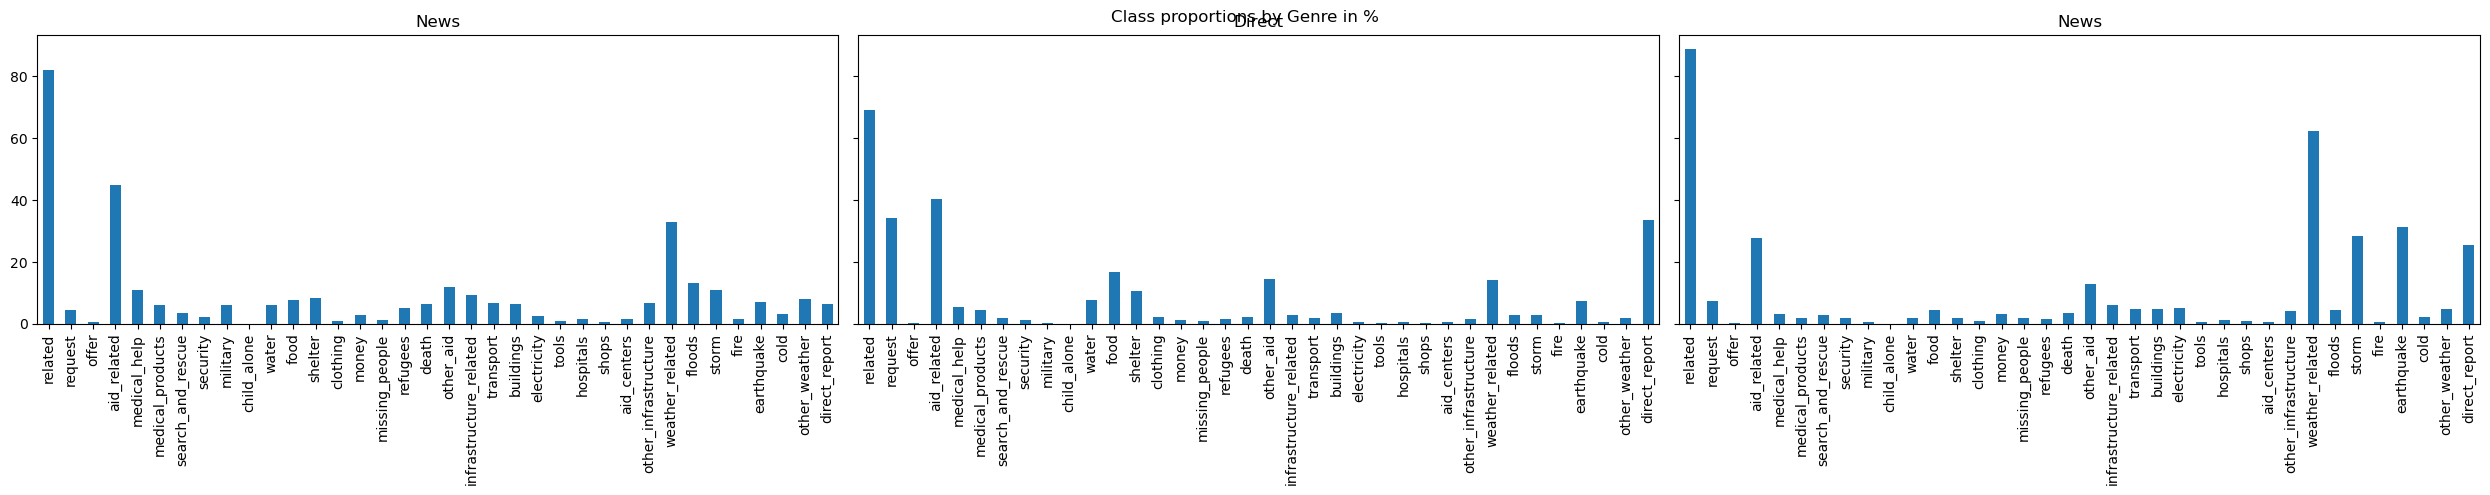

In [227]:
f, ax = plt.subplots(1,3, figsize=(25,5), sharey=True)
(df_news[category_colnames].sum(axis=0)/len(df_news)*100).plot(kind='bar', ax=ax[0], title='News')
(df_direct[category_colnames].sum(axis=0)/len(df_direct)*100).plot(kind='bar', ax=ax[1], title='Direct')
(df_social[category_colnames].sum(axis=0)/len(df_social)*100).plot(kind='bar', ax=ax[2], title='News')
plt.suptitle('Class proportions by Genre in %')
plt.tight_layout()

- exploration of classification labels

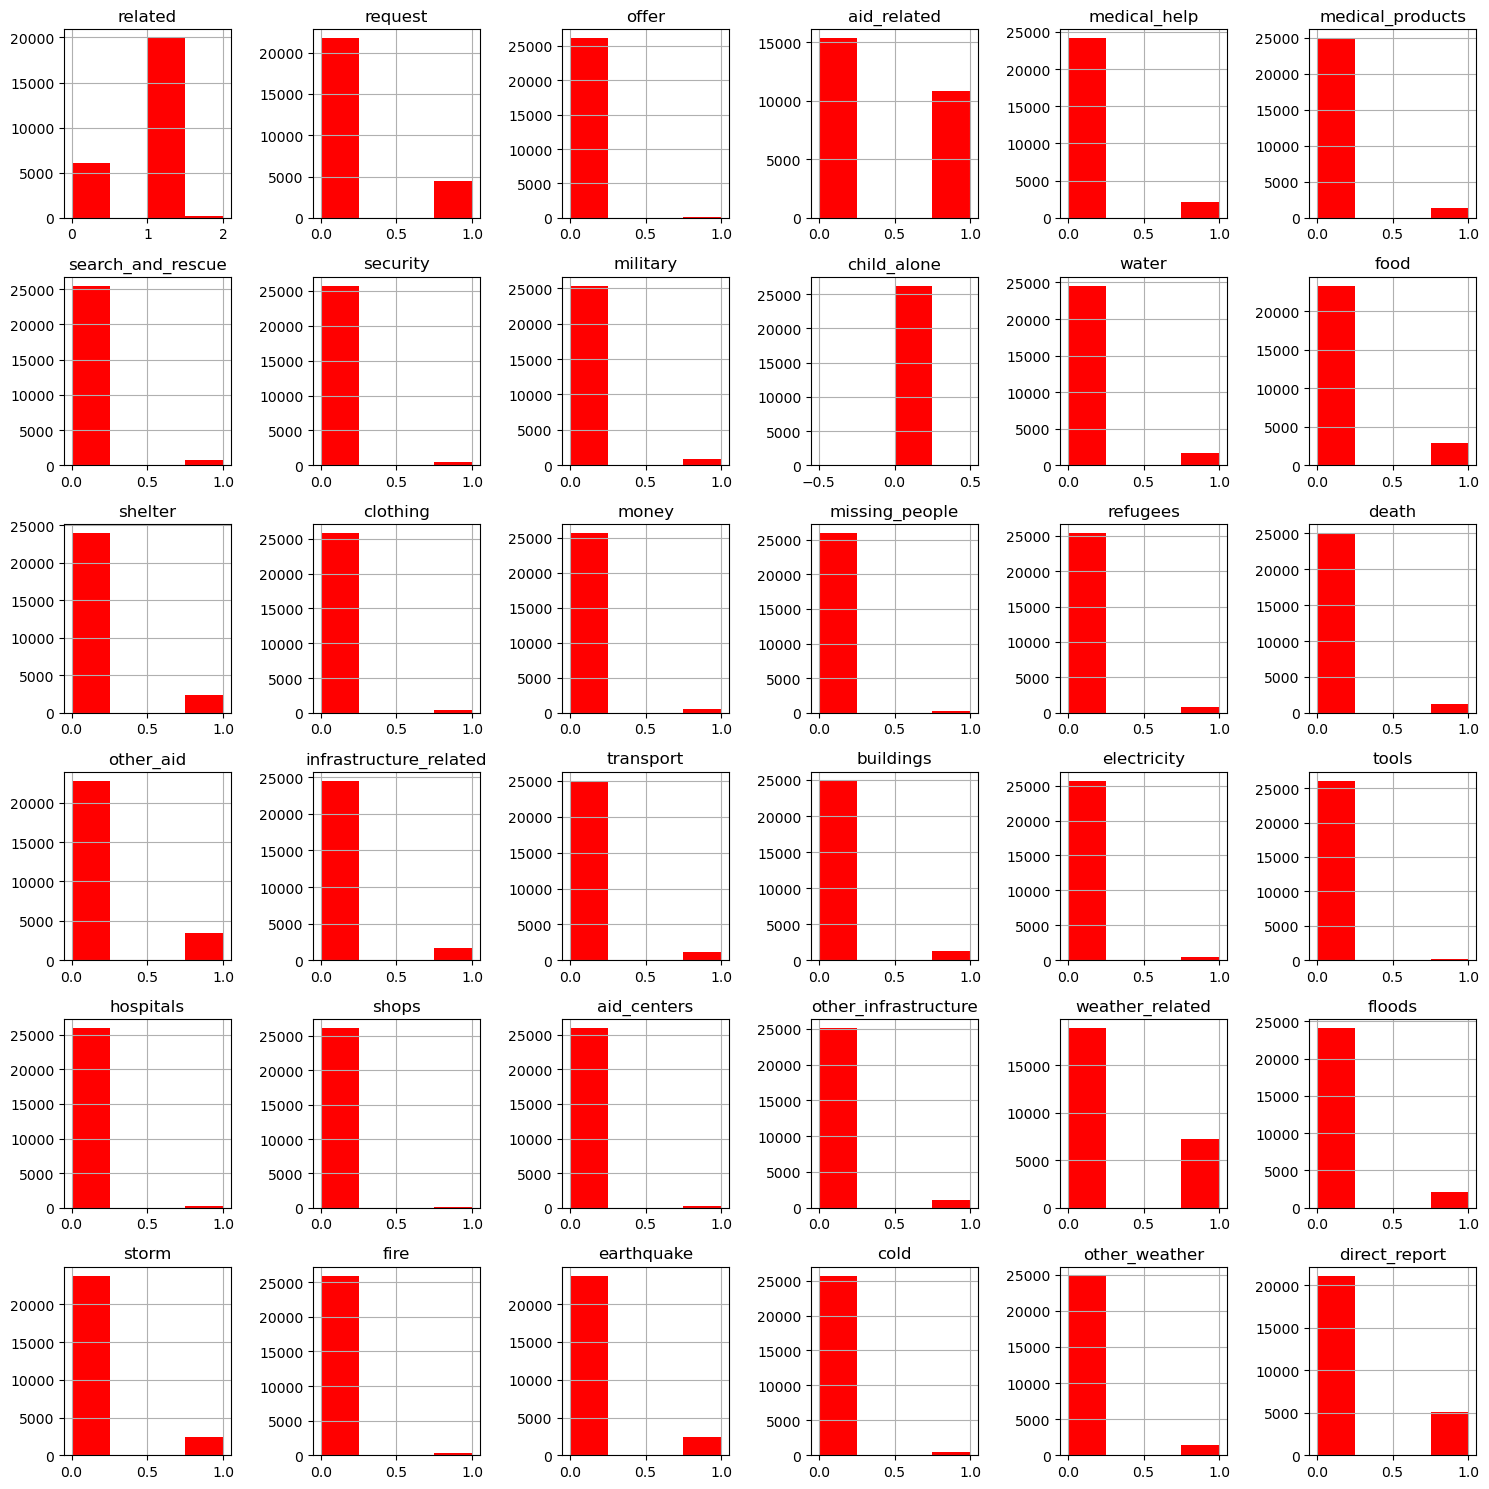

In [30]:
df[category_colnames].hist(bins=4, layout=(6,6), color='r', figsize=(15,15))
plt.tight_layout()
plt.show()

- all variables are binary excepted "related" which dipslays 3 options (0,1,2)

In [32]:
df.related.value_counts()

1    19906
0     6121
2      188
Name: related, dtype: int64

In [33]:
df[df.related==2]

,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
146,Dans la zone de Saint Etienne la route de Jacm...,Nan zon st. etine rout jakmel la bloke se mize...,direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,. .. i with limited means. Certain patients co...,t avec des moyens limites. Certains patients v...,direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
373,The internet caf Net@le that's by the Dal road...,Cyber cafe net@le ki chita rout de dal tou pr ...,direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,"Bonsoir, on est a bon repos aprs la compagnie ...",Bonswa nou nan bon repo apri teleko nan wout t...,direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
700,URGENT CRECHE ORPHANAGE KAY TOUT TIMOUN CROIX ...,r et Salon Furterer. mwen se yon Cosmtologue. ...,direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23662,transferred to a sanitary landfill site by a,NaN,news,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23861,Families also have solar lamps which can be re...,NaN,news,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25874,Read the [full blog post](http://www.odi.org.u...,NaN,news,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- let's drop these data to make `related` a binary variable

In [35]:
df = df.drop(df[df.related==2].index)

### 7. Save the clean dataset into an sqlite database.
You can do this with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) combined with the SQLAlchemy library. Remember to import SQLAlchemy's `create_engine` in the first cell of this notebook to use it below.

In [37]:
# Note that you need three slashes in sqlite:/// in order to use a relative path for the DB. 
# If you want an absolute path, use four slashes: sqlite:////.

engine = create_engine('sqlite:///./data/DisasterResponse.db' )
df.to_sql('messages', engine, index=False, if_exists='replace')

26026

In [38]:
# CHECK
import sqlite3
# connect to the data base
conn = sqlite3.connect('./data/DisasterResponse.db')

# run a query
pd.read_sql('SELECT * FROM messages', conn)


,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26021,The training demonstrated how to enhance micro...,None,news,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26022,A suitable candidate has been selected and OCH...,None,news,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26023,"Proshika, operating in Cox's Bazar municipalit...",None,news,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26024,"Some 2,000 women protesting against the conduc...",None,news,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 8. Use this notebook to complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.